# <center> EfficientNets Experiments </center>

# Table of contents

1. [Dataset preparation](#data_preparation)
    1. [Label extraction](#label_extraction)
    2. [Partition creation](#partition)
    3. [Data generation](#data_gen)
    4. [Data storage and loading](#data_storage)
3. [Visual inspection of data](#data_viz)
4. [Modeling Phase](#model)
    1. [Evaluation](#model_eval)
    2. [Architecture](#model_arch)
5. [EfficientNets](#ef_net)
6. [Results](#res)
    1. [Multi class](#multi_class)
    2. [Binary class](#bin)
    3. [SNP / Indels](#snp_indels_res)
    3. [VCF Evaluation](#vcf)


    

# Imports

In [4]:
# If a GPU is busy, use the available one
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

!export CUDA_VISIBLE_DEVICES=1

In [5]:
%matplotlib inline

import os
import sys
import json
import keras
import pysam
import warnings

import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from PIL import Image
from itertools import islice


from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers  import *
from keras_efficientnets import *
from keras.metrics import *

from keras.activations import *
from keras.utils import multi_gpu_model, Sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import *
from inspect import signature


from conv_net_utils import *

warnings.filterwarnings("ignore")
np.random.seed(1997)
from tensorflow import set_random_seed
set_random_seed(1997)

print("Keras version   :", keras.__version__)
print("Number of cores :", os.cpu_count())
print("GPU infos       :")
!nvidia-smi
#watch -n0.5 nvidia-smi in the terminal to monitor GPU usage

Keras version   : 2.2.4
Number of cores : 56
GPU infos       :
Mon Jul 29 11:19:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro M6000 24GB   Off  | 00000000:02:00.0 Off |                  Off |
| 44%   73C    P0   179W / 250W |  12600MiB / 24475MiB |     26%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro M6000 24GB   Off  | 00000000:03:00.0 Off |                  Off |
| 57%   83C    P0   226W / 250W |  23593MiB / 24476MiB |    100%      Default |
+------------------------

In [4]:
path_train = "/mnt/genomics002/calva/out/pileups/mixture_HG001_HG002/chr21/"
path_test  = "/mnt/genomics002/calva/out/pileups/mixture_HG001_HG002/chr22/"

Load the partition data

In [5]:
with open('Data/partition.json', 'r') as f:
    partition = json.load(f)

In [6]:
list_indx_train = partition['train']
list_indx_valid = partition['valid']
list_indx_test  = partition['test']

list_indx_train_downsampled = partition['train_downsampled']
list_indx_valid_downsampled = partition['valid_downsampled']
list_indx_test_downsampled  = partition['test_downsampled']


rnd_pos_train = np.random.choice(list_indx_train, size=10000, replace=False)
rnd_pos_valid = np.random.choice(list_indx_valid, size=1000, replace=False)
rnd_pos_test = np.random.choice(list_indx_test, size=10000, replace=False)

labels_chr21_encoded = {int(i) : j for i, j in partition['labels_chr21_encoded'].items()}
labels_chr22_encoded = {int(i) : j for i, j in partition['labels_chr22_encoded'].items()}

## Data Generation <a name="data_gen"></a>

### Loading and processing pileups images

### Data Generator

In [6]:
floor = np.floor
shuffle = np.random.shuffle

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels=None, batch_size=32, shuffle=True, train=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.labels = labels
        
        if train:
            self.path = path_train
            self.chr  = "chr21_"
            self.datagen = self.__data_generation
            
        else:
            self.path = path_test
            self.chr  = "chr22_"
            self.y_test = [self.labels[i] for i in self.list_IDs]
            self.datagen = self.__data_generation_test
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        return self.datagen(list_IDs_temp)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, 299, 299, 5)
        # Initialization
        X = empty((self.batch_size, 299, 299, 5))
        y = empty((self.batch_size, 3))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            filename = self.path + str(ID)[0:2] + "/" + self.chr + str(ID) + ".pgm"
            X[i, ] = read_pgm_ref(filename)
            # Store class
            y[i] = self.labels[ID]
        return X, y
    
    def __data_generation_test(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, 299, 299, 5)
        # Initialization
        X = empty((self.batch_size, 299, 299, 5))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            filename = self.path + str(ID)[0:2] + "/" + self.chr + str(ID) + ".pgm"
            X[i, ] = read_pgm_ref(filename)
        return X

In [7]:
my_batch_size = 64
batch_train = DataGenerator(list_IDs=list_indx_train, labels=labels_chr21_encoded, batch_size=my_batch_size)
batch_valid = DataGenerator(list_IDs=list_indx_valid, labels=labels_chr21_encoded, batch_size=my_batch_size)

## Data storage and loading <a name="data_storage"></a>

### Load dataset in memory

In [6]:
X_train, y_train = load_data_set_from_pileups(path_train, list_indx_train_downsampled, labels_chr21_encoded)
X_valid, y_valid = load_data_set_from_pileups(path_train, list_indx_valid_downsampled, labels_chr21_encoded)
X_test, y_test   = load_data_set_from_pileups(path_test,  list_indx_test_downsampled,  labels_chr22_encoded, test=True)

print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

Size of dataset :  26742
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
(26742, 299, 299, 5)
(26742, 3)


# Modeling phase <a name="model"></a>

## Get class weights to fight imbalanced dataset

In [20]:
class_weights_dict = get_class_weights2(np.array(list(labels_chr21_encoded.values())))
print(class_weights_dict)

{0: 0.4132900131507697, 1: 1.7265382626680454, 2: 834.78125}


## Architecture <a name="model_arch"></a>

### 1-cycle policy callback

In [ ]:
sys.path.insert(0, './OneCycle')
from clr import LRFinder, OneCycleLR

N = X_train.shape[0] # number of points
my_batch_size = 64
min_lr = 0.001
max_lr = 0.5

lr_callback = LRFinder(N, my_batch_size,
                       min_lr, max_lr,
                       lr_scale='exp', save_dir='./OneCycle/')
# Ex :
# Ensure that number of epochs = 1 when calling fit()
# model.compile(optimizer="Adam", loss='categorical_crossentropy')
# model.fit(X_train, y_train,  epochs=1, batch_size=128, callbacks=[lr_callback])

# lr_callback.plot_schedule() -> visual inspection

In [2]:
class Swish(Layer):

    def __init__(self, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.supports_masking = True
        self.__name__ = "swish"

    def call(self, inputs, training=None):
        return tf.nn.swish(inputs)


def conv2d_bn_swish(x, filters, num_row, num_col, padding='same', 
              strides=(1, 1), name="first_block"):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, name=conv_name)(x)
    x = BatchNormalization(axis=3, scale=True, name=bn_name)(x)
    x = Swish()(x)
    return x

NameError: name 'Layer' is not defined

In [8]:
def create_network(input_shape, keras_model):
    '''Conv Network architecture, based on a keras model
    '''
    inp = Input(shape=input_shape)
    
    x = conv2d_bn_swish(inp, 5, 299, 1, name="first_block")
    x = conv2d_bn_swish(x, 5, 5, 5, name="first_block1")
    
    base_model = keras_model(input_tensor=inp, weights=None, include_top=False, input_shape=input_shape, pooling="avg")
    
    x = base_model.output
    
    x = Dense(1024, activation=Swish(), use_bias=True)(x)
    x = Dropout(0.5)(x)
    x = Dense(200, activation=Swish(), use_bias=True)(x)
    x = Dropout(0.2)(x)
    predictions = Dense(3, activation="softmax")(x)
    return Model(inp, predictions)

# EfficientNet B2 <a name="ef_net"></a>

In [11]:
model_EfficientNetB2 = create_network((299, 299, 5), EfficientNetB2)
model_EfficientNetB2.compile("Adam", loss='categorical_crossentropy', metrics=[categorical_accuracy])

model_EfficientNetB2.summary()

min_size 32
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 5)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 32) 1440        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 150, 150, 32) 0           batch_normalization_1[0][0

In [ ]:
# Full pass over the dataset to find maximal learning rate
model_EfficientNetB2.fit(X_train, y_train,  epochs=1, batch_size=64, callbacks=[lr_callback])

In [ ]:
lr_callback.plot_schedule() # visual inspection to determine max learning_rate

-2.6 is the last relatively smooth portion before the -2.4 plateau region.
To be safe, we can choose to move a little more to the left, closer to -2.7, but this will reduce the performance.

-2.5 is therefore chosen to be the maximum learning rate (in log10 space) for the OneCycleLR schedule. 
Since this is in log10 scale, we use  $10^{−2.5} ≈ 0.003$  to get the actual learning maximum learning rate.

In [21]:
my_callbacks = get_callbacks("Models/weights_EfficientNetB2_CNN.hdf5", "val_categorical_accuracy", max_lr=0.003)

hist = model_EfficientNetB2.fit(X_train, y_train, epochs=100, batch_size=64,
                                validation_data=(X_valid, y_valid),
                                callbacks=my_callbacks)

Train on 24880 samples, validate on 6128 samples
Epoch 1/100
24880/24880 [==============================] - 1103s 44ms/step - loss: 0.2808 - categorical_accuracy: 0.8893 - val_loss: 0.2284 - val_categorical_accuracy: 0.9231
 - lr: 0.00036 
Epoch 2/100
24880/24880 [==============================] - 1069s 43ms/step - loss: 0.1306 - categorical_accuracy: 0.9473 - val_loss: 0.1485 - val_categorical_accuracy: 0.9458
 - lr: 0.00042 
Epoch 3/100
24880/24880 [==============================] - 1080s 43ms/step - loss: 0.0982 - categorical_accuracy: 0.9626 - val_loss: 0.1761 - val_categorical_accuracy: 0.9421
 - lr: 0.00048 
Epoch 4/100
24880/24880 [==============================] - 1077s 43ms/step - loss: 0.0795 - categorical_accuracy: 0.9702 - val_loss: 0.2014 - val_categorical_accuracy: 0.9368
 - lr: 0.00054 
Epoch 5/100
24880/24880 [==============================] - 1078s 43ms/step - loss: 0.0652 - categorical_accuracy: 0.9769 - val_loss: 0.1712 - val_categorical_accuracy: 0.9488
 - lr: 0.000

In [22]:
model_EfficientNetB2.save_weights("Models/best_weights_EfficientNetB2_CNN.hdf5")

In [10]:
model_EfficientNetB2 = create_network((299, 299, 5), EfficientNetB2)
model_EfficientNetB2.load_weights("Models/best_weights_EfficientNetB2_CNN.hdf5")

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [11]:
y_pred = model_EfficientNetB2.predict(X_test, verbose=1)

26742/26742 [==============================] - 550s 21ms/step


In [12]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [15]:
f1_score(y_pred_bin, y_test_bin, average="weighted")

0.9752908716015767

In [22]:
missclassified = np.where(y_pred_bin != y_test_bin)

In [35]:
np.save("Results/missclassified.npy",np.array(list_indx_test_downsampled)[missclassified])

In [40]:
np.array(list_indx_test_downsampled)[missclassified]

array([32376725, 19883944, 32364836, 31777264, 32403406, 30850306,
       30405068, 24750681, 40657336, 34745814, 41440284, 21823941,
       35125750, 29880133, 49359830, 39335566, 39156392, 41389512,
       19335690, 40634094, 24342672, 30132539, 34616167, 41896140,
       40617726, 26679607, 40459127, 30627598, 40592456, 41656516,
       30041458, 36067293, 19122587, 37187573, 44857929, 24926850,
       40711165, 31294688, 32965543, 32069517, 26721040, 35403936,
       36452390, 26910251, 41254983, 31043890, 30041425, 49819053,
       34552922, 32419411, 36546492, 38338938, 31368152, 34028013,
       29251381, 48593501, 37841557, 18942225, 31664064, 46388348,
       29449349, 42838292, 42999668, 20887224, 47005617, 37900161,
       30632836, 21785973, 41686304, 42057551, 25111769, 43411714,
       20397081, 34423166, 29324419, 20962269, 39390911, 19581758,
       19269947, 38977041, 27407653, 46669656, 49834808, 44442300,
       21798717, 32381332, 36081443, 43148288, 30716044, 46232

In [36]:
np.save("Results/y_pred_downsampled.npy", y_pred)

In [37]:
np.save("Results/y_test_downsampled.npy", y_test)

In [38]:
np.save("Data/list_indx_test_downsampled.npy", list_indx_test_downsampled)

# Results <a name="res"></a>

## multi-class results <a name='multi_class'></a>

26742/26742 [==============================] - 308s 12ms/step

Evaluation on 26742 images from the test set :

Random predictions :
Accuracy  :	 0.332
Precision :	 0.497
Recall    :	 0.332
F1-score  :	 0.397


Only majority class :
Accuracy  :	 0.501
Precision :	 0.251
Recall    :	 0.501
F1-score  :	 0.334


Actual predictions :
Accuracy  :	 0.974
Precision :	 0.973
Recall    :	 0.974
F1-score  :	 0.973




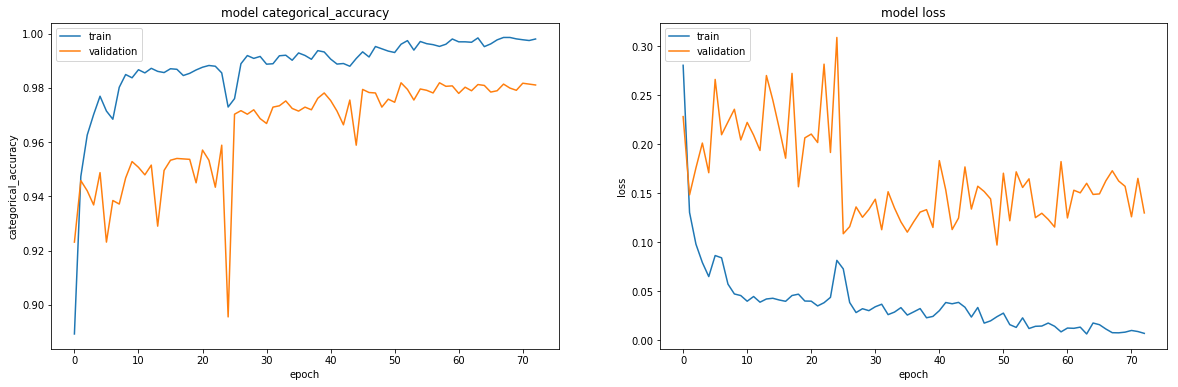

In [124]:
y_pred, missclassified_img = eval_model(hist, X_test, y_test, generator=False, verbose=1, plot=True)

In [140]:
print("Number of badly classified images : ", y_pred[missclassified_img].shape[0])
print("Number of 1-2 predicted :", np.where(y_pred[missclassified_img] == 2)[0].shape[0])
print("Number of 0-1 predicted :", np.where(y_pred[missclassified_img] == 1)[0].shape[0])
print("Number of 0-0 predicted :", np.where(y_pred[missclassified_img] == 0)[0].shape[0])

Number of badly classified images :  706
Number of 1-2 predicted : 0
Number of 0-1 predicted : 276
Number of 0-0 predicted : 430


## Binary class results <a name="bin"></a>

In [19]:
y_pred_prob = []
for i in y_pred:
    if np.argmax(i) == 0:
        y_pred_prob.append(1 - i[0])
    else:
        y_pred_prob.append(i[np.argmax(i)])
        
y_pred_prob = np.array(y_pred_prob)




y_pred_flat = np.argmax(y_pred, axis=1)
y_pred_bin  = np.array([1 if i==2 else i for i in y_pred_flat])

y_test_flat = np.argmax(y_test, axis=1)
y_test_bin  = np.array([1 if i==2 else i for i in y_test_flat])

In [31]:
print("Using argmax for predictions :\n ")

print("accuracy_score for whole test set : ", accuracy_score(y_test_bin, y_pred_bin) * 100)
print("precision for whole test set : ", precision_score(y_test_bin, y_pred_bin, average="weighted") * 100)
print("recall for whole test set : ", recall_score(y_test_bin, y_pred_bin, average="weighted") * 100)
print("f1-score for whole test set : ", f1_score(y_test_bin, y_pred_bin, average="weighted") * 100)

Using argmax for predictions :
 
accuracy_score for whole test set :  97.91981422416205
precision for whole test set :  97.97922691773485
recall for whole test set :  97.91981422416205
f1-score for whole test set :  97.93794428781655


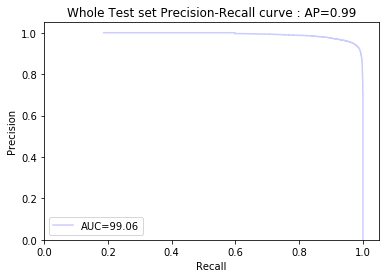

In [48]:
average_precision = average_precision_score(y_test_bin, y_pred_prob)

precision, recall, tr = precision_recall_curve(y_test_bin, y_pred_prob)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(precision, recall, color='b', alpha=0.2,
         where='post')
#plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Whole Test set Precision-Recall curve : AP={0:0.2f}'.format(
          average_precision))
plt.legend(["AUC={0:0.2f}".format(auc(recall, precision) * 100)])
plt.show()

In [50]:
print("Using 0.9 as threshold :\n ")

print("accuracy_score for whole test set : {0:0.3f}".format(accuracy_score(y_test_bin, y_pred_prob > 0.9) * 100))
print("precision for whole test set : {0:0.3f}".format(precision_score(y_test_bin, y_pred_prob > 0.9, average="weighted") * 100))
print("recall for whole test set : {0:0.3f}".format(recall_score(y_test_bin, y_pred_prob > 0.9, average="weighted") * 100))
print("f1-score for whole test set : {0:0.3f}".format(f1_score(y_test_bin, y_pred_prob > 0.9, average="weighted") * 100))

Using 0.9 as threshold :
 
accuracy_score for whole test set : 98.485
precision for whole test set : 98.477
recall for whole test set : 98.485
f1-score for whole test set : 98.479


### Exemple pipeline évaluation

<b>Idée</b> : Ce qui compte réellement dans une application clinique c'est de trouver tous les variants somatiques, c'est-à-dire maximiser les vrais positifs et minimiser les faux négatifs.

Les faux positifs ne sont pas spécialement problématique puisqu'un expert regardera les positions selectionnées. De même, la majorité des positions est non-variant donc les vrais négatifs ne sont pas importants. 

Il faut donc tracer la courbe précision-recall et faire en sorte de choisir le bon threshold afin de maximiser le recall pour une précision suffisamment bonne.


Le recall est défini comme : $$recall = \frac{TP}{TP + FN}$$

(C'est la capacité du classifieur à trouver tous les variants somatiques)

La précision est définie comme : $$precision = \frac{TP}{TP + FP}$$

(C'est la capacité du classifieur à détecter uniquement des variants réellement somatiques)

Pour résumer ces informations en une seule métrique, on peut : 
- 1) choisir le threshold de façon à maximiser le recall tout en conservant une bonne précision 
- 2) calculer le $F_{\beta}$-score définit par : $$F_{\beta} = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$$


Ce score donne plus d'importance au recall d'un facteur $\beta$, si $\beta = 1$ alors ce score est le $F_1$-score classique et la précision et le recall ont la même importance. 

On peut ainsi utiliser le score $F_2$ signifiant que le recall est deux fois plus important que la précision pour notre application.

In [115]:
y_test = np.load("Data/y_test.npy")
y_pred = np.load("Results/y_pred_multiclass_B2.npy")

In [116]:
y_test = np.argmax(y_test, axis=1)
y_test = np.array([1 if i==2 else i for i in y_test])

In [119]:
def evaluate(y_test, y_prob, min_precision, max_precision, min_recall, beta=2, plot=True):
    """Helper function to evaluate the quality of predictions. The goal is to maximize recall while
       keeping a good precision.
       Args:
       y_test : ground truth (0 or 1 label, shape (N, ))
       y_prob : predicted probabilities for the positive class (shape (N, )) or predicted probabilities (shape (N, n_classes))
       beta   : beta parameter to f_beta score, beta -> 0 only keeps precision, beta -> inf only keeps recall
       min_precision : minimum expected precision
       max_precision : if set too high, output of recall will be close to 0
       min_recall    : minimum expected recall
       plot : whether to plot precision-recall curve"""
    
    if y_prob.shape != y_test.shape:
        print("Reshaping output probabilities from {} to {}...\n".format(y_prob.shape, y_test.shape))
        y_pred_prob = []
        for i in y_prob:
            if np.argmax(i) == 0:
                y_pred_prob.append(1 - i[0])
            else:
                y_pred_prob.append(i[np.argmax(i)])
        y_pred_prob = np.array(y_pred_prob)
        y_prob = y_pred_prob
        
    
    precision, recall, tr = precision_recall_curve(y_test, y_prob)
    indx = np.where((min_precision <= precision) & (precision < max_precision))[0]
    
    m = 0
    threshold = 0
    min_recall = 0.9
    indx_opti = 0
    for i in indx:
        if recall[i] > min_recall and recall[i] > m:
            m = recall[i]
            threshold = tr[i]
            indx_opti = i
    
    print("Precision : ", precision[indx_opti])
    print("Recall : ", recall[indx_opti])
    print("f_{} score : {}".format(beta, fbeta_score(y_test, (y_prob >= threshold), beta=beta)))
    
    if plot:
        step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
        plt.step(precision, recall, color='b', alpha=0.2,
                 where='post')
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('Precision-Recall curve')
        plt.legend(["AUC={0:0.2f}".format(auc(recall, precision) * 100)])
        plt.plot(precision[indx_opti], recall[indx_opti], "ro")
        plt.show()
        
    return precision, recall, tr, indx_opti
        


Reshaping output probabilities from (71484, 3) to (71484,)...

Precision :  0.9000414479137884
Recall :  0.9744222571236257
f_2 score : 0.9585785756327252


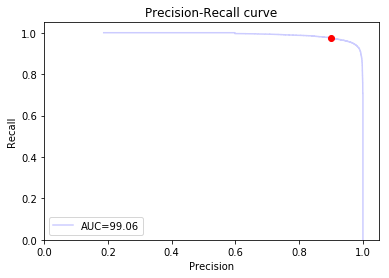

In [120]:
precision, recall, tr, indx_opti = evaluate(y_test, y_pred, 0.9, 1, 0.9)

## Indels / SNP evaluation <a name="snp_indels_res"></a>

In [122]:
path_truth_vcf = "Data/na12878-na24385-somatic-hg38-truth.vcf"

In [123]:
def get_snp_indels(fname, nlines, printl=False):
    with open(fname) as f:
        labels_ind = {'0-1' : [], '1-2' : [], 'snp' : [], 'indels' : []}
        for j, line in enumerate(islice(f, nlines)):
            if j <= 72:
                continue
                
            line = line.split("\t")
            chro = line[0]
            
            if chro != 'chr22':
                continue
                
            pos  = int(line[1])
            ref  = line[3]
            ref_len = len(ref)
            
            label = line[-1].split(":")[0]
            
            alt  = line[4]
            alts = alt.split(",")
            
            if label == "0/0":
                continue
                
            elif label in ['0/1', '1/0', '0|1', '1|0', '0-1', '1-0']:
                label = '0-1'
                alt_len = len(alts[0])
                
            elif label in ['1/2', '2/1', '1|2', '2|1', '1-2', '2-1']:
                label = '1-2'
                alt_len = max(len(alts[0]), len(alts[1]))

            labels_ind[label].append(pos)
            
            if ref_len == alt_len:
                labels_ind['snp'].append(pos)
            else:
                labels_ind['indels'].append(pos)
                
            if printl:
                print(" :\t ".join((chro, pos, ref, alt, label)))
                
        return labels_ind

In [124]:
snp_indels_dic = get_snp_indels(path_truth_vcf, None, False)

In [129]:
list_variants = labels_chr22_indx['0-1'] + labels_chr22_indx['1-2']

NameError: name 'labels_chr22_indx' is not defined

In [130]:
list_variants_dic = {pos : indx for pos, indx in list_variants}

NameError: name 'list_variants' is not defined

In [63]:
list_pos_test = list_variants_dic.keys()
list_indels_test = set(list_pos_test) - (set(list_pos_test) - set(snp_indels_dic['indels']))
list_snp_test    = set(list_pos_test) - (set(list_pos_test) - set(snp_indels_dic['snp']))

In [68]:
list_indels_indx = [list_variants_dic[i] for i in list_indels_test]
list_snp_indx = [list_variants_dic[i] for i in list_snp_test]

In [69]:
print("Number of snp pos : {}\nNumber of indels pos : {}".format(len(list_snp_indx), len(list_indels_indx)))

Number of snp pos : 11890
Number of indels pos : 1481


In [54]:
X_test_snp, y_test_snp = load_data_set_from_pileups(path_test, list_snp_test, labels_chr22_encoded, test=True)

Size of dataset :  11890
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [59]:
y_pred_snp = model_EfficientNetB2.predict(X_test_snp, verbose=1)

11890/11890 [==============================] - 112s 9ms/step


### Results for SNP 

#### Only SNP

In [76]:
y_pred_snp = y_pred[list_snp_indx]
y_pred_bin_snp = y_pred_bin[list_snp_indx]
y_pred_prob_snp = y_pred_prob[list_snp_indx]

y_test_snp = y_test[list_snp_indx]
y_test_bin_snp = y_test_bin[list_snp_indx]

In [77]:
print("accuracy_score for snp : ", accuracy_score(y_test_bin_snp, y_pred_bin_snp) * 100)
print("precision for snp : ", precision_score(y_test_bin_snp, y_pred_bin_snp) * 100)
print("recall for snp : ", recall_score(y_test_bin_snp, y_pred_bin_snp) * 100)
print("f1-score for snp : ", f1_score(y_test_bin_snp, y_pred_bin_snp) * 100)

accuracy_score for snp :  98.75525651808242
precision for snp :  100.0
recall for snp :  98.75525651808242
f1-score for snp :  99.37373053486796


#### SNP and Germline

In [92]:
list_no_var = [indx for pos, indx in labels_chr22_indx['0-0']]

In [93]:
list_snp_novar = list_no_var + list_snp_indx

In [96]:
print("Using argmax : \n")

print("accuracy_score for snp and germline : ", accuracy_score(y_test_bin[list_snp_novar], y_pred_bin[list_snp_novar]) * 100)
print("precision for snp and germline : ", precision_score(y_test_bin[list_snp_novar], y_pred_bin[list_snp_novar]) * 100)
print("recall for snp and germline : ", recall_score(y_test_bin[list_snp_novar], y_pred_bin[list_snp_novar]) * 100)
print("f1-score for snp and germline : ", f1_score(y_test_bin[list_snp_novar], y_pred_bin[list_snp_novar]) * 100)

Using argmax : 

accuracy_score for snp and germline :  98.28007371112668
precision for snp and germline :  91.7487107360525
recall for snp and germline :  98.75525651808242
f1-score for snp and germline :  95.12313674659754


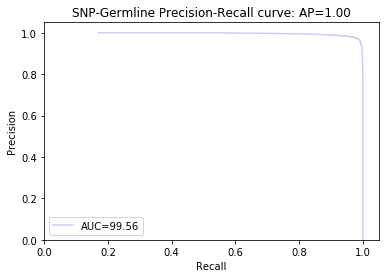

In [95]:
average_precision = average_precision_score(y_test_bin[list_snp_novar], y_pred_prob[list_snp_novar])

precision, recall, tr = precision_recall_curve(y_test_bin[list_snp_novar], y_pred_prob[list_snp_novar])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(precision, recall, color='b', alpha=0.2,
         where='post')
#plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('SNP-Germline Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.legend(["AUC={0:0.2f}".format(auc(recall, precision) * 100)])
plt.show()

In [185]:
print("Using 0.9 as threshold : \n")

print("accuracy_score for snp and germline : ", accuracy_score(y_test_bin[list_snp_novar], y_pred_prob[list_snp_novar] > 0.9) * 100)
print("precision for snp and germline : ", precision_score(y_test_bin[list_snp_novar], y_pred_prob[list_snp_novar] > 0.9) * 100)
print("recall for snp and germline : ", recall_score(y_test_bin[list_snp_novar], y_pred_prob[list_snp_novar] > 0.9) * 100)
print("f1-score for snp and germline : ", f1_score(y_test_bin[list_snp_novar], y_pred_prob[list_snp_novar] > 0.9) * 100)

Using 0.9 as threshold : 

accuracy_score for snp and germline :  99.08575346770853
precision for snp and germline :  96.71150971599403
recall for snp and germline :  97.94785534062237
f1-score for snp and germline :  97.32575630954369


### Results for Indels

#### Only INDELS

In [98]:
y_pred_bin_indel = y_pred_bin[list_indels_indx]

y_test_bin_indel = y_test_bin[list_indels_indx]

In [100]:
print("Using argmax :\n")

print("accuracy_score for indels : ", accuracy_score(y_test_bin_indel, y_pred_bin_indel) * 100)
print("precision for indels : ", precision_score(y_test_bin_indel, y_pred_bin_indel) * 100)
print("recall for indels : ", recall_score(y_test_bin_indel, y_pred_bin_indel) * 100)
print("f1-score for indels : ", f1_score(y_test_bin_indel, y_pred_bin_indel) * 100)

Using argmax :

accuracy_score for indels :  80.89128966914248
precision for indels :  100.0
recall for indels :  80.89128966914248
f1-score for indels :  89.43635684957074


#### INDELS and germline

In [108]:
y_pred_ind_novar = y_pred_bin[list_indels_indx + list_no_var]
y_pred_prob_indels = y_pred_prob[list_indels_indx + no_var]
y_test_ind_novar = y_test_bin[list_indels_indx + list_no_var]


In [107]:
print("accuracy_score for indels and germline : ", accuracy_score(y_test_ind_novar, y_pred_ind_novar) * 100)
print("precision for indels and germline : ", precision_score(y_test_ind_novar, y_pred_ind_novar) * 100)
print("recall for indels and germline : ", recall_score(y_test_ind_novar, y_pred_ind_novar) * 100)
print("f1-score for indels and germline : ", f1_score(y_test_ind_novar, y_pred_ind_novar) * 100)

accuracy_score for indels and germline :  97.75312950968218
precision for indels and germline :  53.149955634427684
recall for indels and germline :  80.89128966914248
f1-score for indels and germline :  64.1499330655957


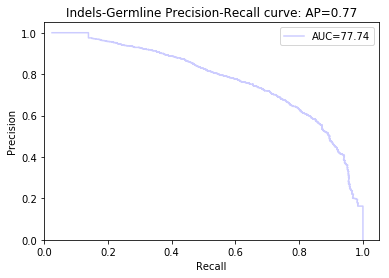

In [111]:
average_precision = average_precision_score(y_test_ind_novar, y_pred_prob_indels)

precision, recall, tr = precision_recall_curve(y_test_ind_novar, y_pred_prob_indels)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(precision, recall, color='b', alpha=0.2,
         where='post')
#plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Indels-Germline Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.legend(["AUC={0:0.2f}".format(auc(recall, precision) * 100)])
plt.show()

#### scoring by indel size : 

In [125]:
def get_indels_size(fname, nlines, printl=False):
    with open(fname) as f:
        labels_ind = {'indels_size' : []}
        for j, line in enumerate(islice(f, nlines)):
            if j <= 72:
                continue
                
            line = line.split("\t")
            chro = line[0]
            
            if chro != 'chr22':
                continue
                
            pos  = int(line[1])
            ref  = line[3]
            ref_len = len(ref)
            
            label = line[-1].split(":")[0]
            
            alt  = line[4]
            alts = alt.split(",")
            
            if label == "0/0":
                continue
                
            elif label in ['0/1', '1/0', '0|1', '1|0', '0-1', '1-0']:
                label = '0-1'
                alt_len = len(alts[0])
                
            elif label in ['1/2', '2/1', '1|2', '2|1', '1-2', '2-1']:
                label = '1-2'
                alt_len = max(len(alts[0]), len(alts[1]))
            
            if ref_len <= alt_len:
                continue
            else:
                labels_ind['indels_size'].append((pos, alt_len))
                
            if printl:
                print(" :\t ".join((chro, pos, ref, alt, label)))
                
        return labels_ind

In [126]:
indels_size = get_indels_size(path_truth_vcf, None, printl=False)

In [127]:
indels_size = {pos : size for pos, size in indels_size['indels_size']}

In [128]:
list_indels_test_size = {pos : indels_size[pos] for pos in list_indels_test}

NameError: name 'list_indels_test' is not defined

In [130]:
Counter(list_indels_test_size.values()) # liste de toutes les pos ac indels et leur taille

Counter({1: 777,
         2: 450,
         3: 99,
         4: 41,
         5: 54,
         6: 14,
         7: 13,
         8: 6,
         9: 10,
         10: 2,
         11: 5,
         12: 2,
         13: 4,
         14: 1,
         15: 1,
         17: 1,
         38: 1})

In [129]:
list_indels_by_size = {i : [] for i in list(Counter(list_indels_test_size.values()).keys())}

In [131]:
for pos, size in list_indels_test_size.items():
    list_indels_by_size[size].append(pos)

In [133]:
list_indels_indx_by_size = {}

for size, pos in list_indels_by_size.items():
    list_indels_indx_by_size[size] = [list_variants_dic[i] for i in pos]

In [143]:
size = []
f1_scores = []

indels size 1 : 

In [ ]:
y_pred_1 = y_pred[list_indels_indx_by_size[1]]
y_test_indel_1 = y_test[list_indels_indx_by_size[1]]
yt  = np.array([1 if i==2 else i for i in np.argmax(y_test_indel_1, axis=1)])
y_pred = np.argmax(y_pred_1, axis=1)

In [145]:
print("accuracy_score for indels : ", accuracy_score(yt, y_pred) * 100)
print("precision for indels : ", precision_score(yt, y_pred) * 100)
print("recall for indels : ", recall_score(yt, y_pred) * 100)
print("f1-score for indels : ", f1_score(yt, y_pred) * 100)
size.append("1")
f1_scores.append(f1_score(yt, y_pred) * 100)

accuracy_score for indels :  85.58558558558559
precision for indels :  100.0
recall for indels :  85.58558558558559
f1-score for indels :  92.23300970873785


indels size 2 : 

In [169]:
y_pred = np.load("Results/y_pred_multiclass_B2.npy")

In [156]:
y_pred_2 = y_pred[list_indels_indx_by_size[2]]
y_test_indel_2 = y_test[list_indels_indx_by_size[2]]
yt  = np.array([1 if i==2 else i for i in np.argmax(y_test_indel_2, axis=1)])
y_pred = np.argmax(y_pred_2, axis=1)

In [157]:
print("accuracy_score for indels : ", accuracy_score(yt, y_pred) * 100)
print("precision for indels : ", precision_score(yt, y_pred) * 100)
print("recall for indels : ", recall_score(yt, y_pred) * 100)
print("f1-score for indels : ", f1_score(yt, y_pred) * 100)
size.append("2")
f1_scores.append(f1_score(yt, y_pred) * 100)

accuracy_score for indels :  68.66666666666667
precision for indels :  100.0
recall for indels :  68.66666666666667
f1-score for indels :  81.42292490118578


indels size 3 : 

In [159]:
y_pred_3 = y_pred[list_indels_indx_by_size[3]]
y_test_indel_3 = y_test[list_indels_indx_by_size[3]]
yt  = np.array([1 if i==2 else i for i in np.argmax(y_test_indel_3, axis=1)])
y_pred = np.argmax(y_pred_3, axis=1)

In [160]:
print("accuracy_score for indels : ", accuracy_score(yt, y_pred) * 100)
print("precision for indels : ", precision_score(yt, y_pred) * 100)
print("recall for indels : ", recall_score(yt, y_pred) * 100)
print("f1-score for indels : ", f1_score(yt, y_pred) * 100)
size.append("3")
f1_scores.append(f1_score(yt, y_pred) * 100)

accuracy_score for indels :  83.83838383838383
precision for indels :  100.0
recall for indels :  83.83838383838383
f1-score for indels :  91.20879120879121


indels size 4 - 5: 

In [162]:
y_pred_4 = y_pred[list_indels_indx_by_size[4] + list_indels_indx_by_size[5]]
y_test_indel_4 = y_test[list_indels_indx_by_size[4] + list_indels_indx_by_size[5]]
yt  = np.array([1 if i==2 else i for i in np.argmax(y_test_indel_4, axis=1)])
y_pred = np.argmax(y_pred_4, axis=1)

In [163]:
print("accuracy_score for indels : ", accuracy_score(yt, y_pred) * 100)
print("precision for indels : ", precision_score(yt, y_pred) * 100)
print("recall for indels : ", recall_score(yt, y_pred) * 100)
print("f1-score for indels : ", f1_score(yt, y_pred) * 100)
size.append("4-5")
f1_scores.append(f1_score(yt, y_pred) * 100)

accuracy_score for indels :  90.52631578947368
precision for indels :  100.0
recall for indels :  90.52631578947368
f1-score for indels :  95.02762430939227


indels size 6-38 :

In [164]:
list_6_38 = [list_indels_indx_by_size[i] for i in [6,7,8,9,10,11,12,13,14,15,17,38]]

In [168]:
list_6_38 = sum(list_6_38, [])

In [170]:
y_pred_5 = y_pred[list_6_38]
y_test_indel_5 = y_test[list_6_38]
yt  = np.array([1 if i==2 else i for i in np.argmax(y_test_indel_5, axis=1)])
y_pred = np.argmax(y_pred_5, axis=1)

In [171]:
print("accuracy_score for indels : ", accuracy_score(yt, y_pred) * 100)
print("precision for indels : ", precision_score(yt, y_pred) * 100)
print("recall for indels : ", recall_score(yt, y_pred) * 100)
print("f1-score for indels : ", f1_score(yt, y_pred) * 100)
size.append("6-38")
f1_scores.append(f1_score(yt, y_pred) * 100)

accuracy_score for indels :  91.66666666666666
precision for indels :  100.0
recall for indels :  91.66666666666666
f1-score for indels :  95.65217391304348


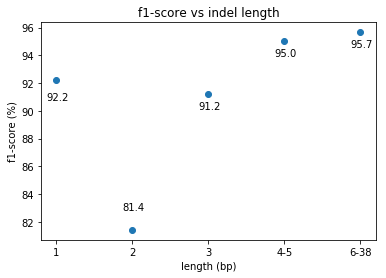

In [174]:
fig, ax = plt.subplots()
ax.scatter(size, f1_scores)

for i, txt in enumerate(f1_scores):
    txt = round(txt, 1)
    if i==0:
        ax.annotate(txt, (size[i], f1_scores[i]), textcoords='offset points', xytext=(-10, -20))
    elif i==1:
        ax.annotate(txt, (size[i], f1_scores[i]), textcoords='offset points', xytext=(-10, 20))
    else:
        ax.annotate(txt, (size[i], f1_scores[i]), textcoords='offset points', xytext=(-10, -15))
        
plt.title("f1-score vs indel length")
plt.xlabel("length (bp)")
plt.ylabel("f1-score (%)")
plt.show()

# Binary class tuning

In [12]:
model_EfficientNetB2.load_weights("Models/weights_EfficientNetB2_CNN.hdf5")

In [41]:
last_layer = model_EfficientNetB2.get_layer('dense_2').output
drop = Dropout(0.2)(last_layer)
out = Dense(1, activation='sigmoid', name='prediction')(drop)
model_pretrained_binary = Model(input=model_EfficientNetB2.input, output=out)

## VCF Generation <a name='vcf'></a>

Dossier où y'a les scripts pour générer le VCF G:\genomics002\calva\abl3GenomicML\BSpGenomicLearning\BSpVariantCallerSolver.m\src\variant_caller

In [13]:
from genomic_utils import WINDOW_WIDTH, WINDOW_HEIGHT, log, getAlleleTuple
import pysam
import numpy as np

imgIndexFile = "/mnt/genomics002/calva/out/pileups/mixture_HG001_HG002/chr22_index_sorted.txt" # path index
imgRootDir = "/mnt/genomics002/calva/out/pileups/mixture_HG001_HG002/chr22/"
modelFilePath= "Models/weights_EfficientNetB2_CNN.hdf5"
vcfSamplePath= "/mnt/genomics002/calva/data/GIAB/na12878-na24385-germline-hg38-truth.vcf" # vcf ex for header

In [14]:
import json
# load the partition data
with open('Data/partition.json', 'r') as f:
    partition = json.load(f)
list_indx_test  = partition['test']

In [ ]:
# load network
log("* Loading model")

model_trained = create_network((299, 299, 5), EfficientNetB2) #doit être correctement instancié

model_trained.load_weights(modelFilePath) 

log("* Loading testing set")

testing_set = X_test
testing_size = testing_set.shape[0]
print("Size of test set : ", testing_size)


In [20]:
## predict and create a vcf
# set to evaluate mode

sampleVCF = pysam.VariantFile(vcfSamplePath)
outVCF = pysam.VariantFile("Results/outVCF.vcf", 'w', header=sampleVCF.header)

In [120]:
log("* predicting on " + str(testing_size) +  " instances ")


predValues = model_trained.predict(X_test, verbose=1)
predClasses = np.argmax(predValues, axis=1)

* predicting on 100 instances 


71484/71484 [==============================] - 1650s 23ms/step


In [15]:
predValues = np.load("Results/y_pred_multiclass_B2.npy")

In [16]:
predClasses = np.argmax(predValues, axis=1)
print(np.max(predClasses))

1


In [7]:
from itertools import islice

# hypothèse que la liste des index est dans l'ordre du VCF ...
def output_metadatas(path_vcf_test, list_indx, verbose=True):
    nlines = len(list_indx) + 2 # on saute le header
    metaInfoList = []
    with open(path_vcf_test) as f:
        i=0
        for line in islice(f, nlines):
            i+=1
            if i > 2:
                line  = line.split("\n")[0].split("\t")
                if line[-1] == '1-2':
                    line[-1] = '0-1'
                metaInfoList.append(line)
                if verbose:
                    print(list_indx[i - 3], line[1])
                    
    return np.array(metaInfoList)

In [8]:
path_vcf_test = '/mnt/genomics002/calva/out/pileups/mixture_HG001_HG002/chr22_index_sorted.txt'

metaInfoList = output_metadatas(path_vcf_test, list_indx_test, False)

In [9]:
np.save("Results/metaInfoList.npy", metaInfoList)

In [23]:
metaInfoList = np.load("Results/metaInfoList.npy")

In [25]:
metaInfoList[0]

array(['chr22', '18925633', 'A>A', 'A>C', 'A>C', '', '0.0359284',
       '1.06764e-06', '8.7722e-28', '0', '0-0'], dtype='<U97')

In [29]:
HOM_REF = 0
HET_REF_ALT = 1

nbInconsistencies = 0

for predValue, predClass, metadata in zip(predValues, predClasses, metaInfoList) :
    
    contig, position, ref, alt01, alt11, alt12, p00, p01, p11, p12, imgLabel = metadata
    predValue = predValue[predClass]

    location = contig + ":" + position
    position = int(position)
    
    if imgLabel=='1-2':
        print(location)
    
    if predClass == HOM_REF: 
          continue

    elif predClass == HET_REF_ALT : 
        if not alt01 : 
        # log("WARNING : no allele 0-1")
            nbInconsistencies += 1 
            continue
        alleleTuple = getAlleleTuple(alt01)
        gt = [0,1]

    else:
          raise Exception("Unknown predicted genotype : " + predClass)


    qual = -10 * np.log(1 - predValue) # Phred-scaled quality score -> best one 
    # qual = int(predValue * 10 ** 5) # Arthur
    # qual = int(100 * predValue)
    if qual < -(2**31 - 1) : qual = -(2 ** 31 - 1)
    if qual > (2**31 - 1)  : qual = 2 ** 31 - 1
    qual = int(qual)
    
    vr = outVCF.new_record(contig=contig, start=position-1, stop=position, alleles=alleleTuple, samples=[{"GT" : gt,"GQ":qual}])
    outVCF.write(vr)
    
log("* found " + str(nbInconsistencies) + " inconsistencies")

* found 0 inconsistencies


### reindex output vcf

In [16]:
path_bed = "/mnt/genomics002/calva/data/GIAB/na12878-na24385-somatic-hg38-truth-regions-sorted.bed.gz"
path_out_vcf = "/home/users/cec1/Results/outVCF.vcf"
path_out_vcf_sorted = "/home/users/cec1/Results/out_sorted.vcf"
path_truth_vcf = "/mnt/genomics002/calva/data/GIAB/na12878-na24385-somatic-hg38-truth.vcf.gz"
path_truth_vcf_modified = "/home/users/cec1/Data/somatic-hg38-truth_modified.vcf"

path_outputs = "/home/users/cec1/outputs"
path_grch38  = "/mnt/genomics002/calva/data/RTG/GRCh38_hs38d1.sdf"

path_bgzip = "/mnt/genomics002/utilities/samtools/htslib-1.9/bgzip"
path_tabix = "/mnt/genomics002/utilities/samtools/htslib-1.9/tabix"
path_rtg   = "/mnt/genomics002/utilities/rtg-tools-3.10.1/rtg"

In [17]:
! {path_bgzip} -c {path_truth_vcf_modified} > {path_truth_vcf_modified + ".gz"}
! {path_tabix} -p vcf {path_truth_vcf_modified}

In [30]:
# sort vcf by pos
! cat {path_out_vcf} | awk '$1 ~ /^#/ {print $0;next} {print $0 | "sort -k1,1 -k2,2n"}' > {path_out_vcf_sorted}

In [31]:
! {path_bgzip} -c {path_out_vcf_sorted} > {path_out_vcf_sorted + ".gz"}
! {path_tabix} -p vcf {path_out_vcf_sorted + ".gz"}

In [11]:
! {path_rtg}  vcfeval -b {path_truth_vcf} -c {path_out_vcf_sorted} -o {path_outputs} --region=chr22 -t {path_grch38}

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
----------------------------------------------------------------------------------------------------
   32.000              12499          12501        280       1661     0.9781       0.8827     0.9279
     None              12835          12837       1164       1325     0.9169       0.9064     0.9116



Lot of false negatives position were not in the test set : 

In [9]:
def list_indx_not_present(path_vcf, verbose=True):
    index = []
    with open(path_vcf) as f:
        i=0
        for line in islice(f, None):
            i+=1
            if i > 74:
                line  = line.split("\n")[0].split("\t")
                index.append(int(line[1]))
                if verbose:
                    print(line)
                    
    return index

In [39]:
path_vcf = "outputs/fn.vcf"
index_fn_vcf = list_indx_not_present(path_vcf, False)
nb_mismatchs = 0

for i in index_fn_vcf:
    if i not in list_indx_test:
        nb_mismatchs+=1

In [42]:
print("no threshold")
print("nb of images not present in the test set = ", nb_mismatchs)
print("true nb of false negative = ", 1325 - nb_mismatchs)
print("true sensitivity = ",100 * 12501 / (12501 + 544))
print("true F-measure   = ", 200 * (0.9584 * 0.9781) / (0.9584 + 0.9781) )
print("gap between F-measures = ", 97.9379 - 96.8149)

no threshold
nb of images not present in the test set =  781
true nb of false negative =  544
true sensitivity =  95.82981985435032
true F-measure   =  96.8149796023754
gap between F-measures =  1.1230000000000047


# Custom Efficient Nets 

In [7]:
class Swish(Layer):

    def __init__(self, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.supports_masking = True
        self.__name__ = "swish"

    def call(self, inputs, training=None):
        return tf.nn.swish(inputs)


def conv2d_bn_swish(x, filters, num_row, num_col, padding='same', 
              strides=(1, 1), name="first_block"):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, name=conv_name)(x)
    x = BatchNormalization(axis=3, scale=True, name=bn_name)(x)
    x = Swish()(x)
    return x

In [8]:
BLOCK_LIST = [
    BlockArgs(32, 16, kernel_size=3, strides=(1, 1), num_repeat=1, se_ratio=0.25, expand_ratio=1),
    BlockArgs(16, 24, kernel_size=3, strides=(2, 2), num_repeat=2, se_ratio=0.25, expand_ratio=6),
    BlockArgs(24, 40, kernel_size=5, strides=(2, 2), num_repeat=2, se_ratio=0.25, expand_ratio=6),
    BlockArgs(40, 80, kernel_size=3, strides=(2, 2), num_repeat=3, se_ratio=0.25, expand_ratio=6),
    BlockArgs(80, 112, kernel_size=5, strides=(1, 1), num_repeat=3, se_ratio=0.25, expand_ratio=6)
]


In [9]:
inp = Input(shape=(299, 299, 5))
x = conv2d_bn_swish(inp, 10, 299, 1, name="first_block")
x = SpatialDropout2D(0.1)(x)

base_model =  EfficientNet(input_shape=None,
                        block_args_list = BLOCK_LIST,
                        width_coefficient=1.1,
                        depth_coefficient=1.2,
                        include_top=False,
                        weights=None,
                        input_tensor=x,
                        pooling="avg",
                        drop_connect_rate=0.1)
x = base_model.output
x = Dense(1024, activation=Swish(), use_bias=True)(x)
x = Dropout(0.5)(x)
x = Dense(200, activation=Swish(), use_bias=True)(x)
predictions = Dense(2, activation="softmax")(x)



Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [10]:
model = Model(inp, predictions)

In [11]:
y_train_bin = np.array([[1., 0.] if all(i == [1., 0., 0.]) else [0., 1.] for i in y_train])
y_valid_bin = np.array([[1., 0.] if all(i == [1., 0., 0.]) else [0., 1.] for i in y_valid])
y_test_bin  = np.array([[1., 0.] if all(i == [1., 0., 0.]) else [0., 1.] for i in y_test])

In [ ]:
# model checkpoint will works only when using solo GPU
def get_callbacks(weights_path, monitored_quantity, patience=15):
    
    model_checkpoint = ModelCheckpoint(weights_path, monitor=monitored_quantity, save_best_only=True,
                                   save_weights_only=True, mode='max')

    early_stopping = EarlyStopping(monitor=monitored_quantity, patience=patience, restore_best_weights=True, mode="max", verbose=1)


    return [model_checkpoint, early_stopping]

my_callbacks = get_callbacks("Models/weights_Custom_EfficientNet.hdf5", "val_categorical_accuracy")


Train on 24880 samples, validate on 6128 samples
Epoch 1/100
24880/24880 [==============================] - 1223s 49ms/step - loss: 0.2323 - categorical_accuracy: 0.9105 - val_loss: 0.1668 - val_categorical_accuracy: 0.9426
Epoch 2/100
24880/24880 [==============================] - 1197s 48ms/step - loss: 0.1325 - categorical_accuracy: 0.9549 - val_loss: 0.1007 - val_categorical_accuracy: 0.9644
Epoch 3/100
24880/24880 [==============================] - 1200s 48ms/step - loss: 0.1075 - categorical_accuracy: 0.9633 - val_loss: 0.1062 - val_categorical_accuracy: 0.9675
Epoch 4/100
24880/24880 [==============================] - 1201s 48ms/step - loss: 0.0936 - categorical_accuracy: 0.9678 - val_loss: 0.0863 - val_categorical_accuracy: 0.9703
Epoch 5/100
24880/24880 [==============================] - 1202s 48ms/step - loss: 0.0826 - categorical_accuracy: 0.9698 - val_loss: 0.0950 - val_categorical_accuracy: 0.9683
Epoch 6/100
24880/24880 [==============================] - 1201s 48ms/step -

In [ ]:
model.compile("Adam",loss='categorical_crossentropy', metrics=[categorical_accuracy])

hist = model.fit(X_train, y_train_bin, epochs=100, batch_size=64,
                                validation_data=(X_valid, y_valid_bin),
                                callbacks=my_callbacks)

In [ ]:
model.load_weights("Models/weights_Custom_EfficientNet.hdf5")

In [ ]:
hist = model.fit(X_train, y_train_bin, epochs=100, batch_size=64,
                                validation_data=(X_valid, y_valid_bin),
                                callbacks=my_callbacks)

In [ ]:
(np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / 26742) * 100

Only majority class :
Accuracy  :	 0.501
Precision :	 0.251
Recall    :	 0.501
F1-score  :	 0.334



Random predictions :
Accuracy  :	 0.332
Precision :	 0.497
Recall    :	 0.332
F1-score  :	 0.397